In [93]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.insert(0, os.path.abspath('../code'))

from methods_time_integrals import find_Rnod, integrate, integrating_factor

In [94]:
# Define the data path where datasets are stored
datapath = "../data/"

# Define the drag coefficient
dt = 60*60*24

H = 3114
rho = 1025
Cd = 0.003

# Define the filenames for the datasets 
A4_file = "A4/A4_lofoten_h_50km_timeseries.nc" 
L800_file = "lofoten800/lofoten800_lofoten_h_50km_timeseries.nc" 

# Load the datasets using xarray
ts_A4 = xr.open_dataset(datapath + A4_file)
ts_L800 = xr.open_dataset(datapath + L800_file).sel(ocean_time=slice("01.01.1997", None))

# Adjusting surface stress
ts_A4["taucirc_area"] = ts_A4.taucirc_area/(H*rho)

ts_L800["taucirc_area"] = ts_L800.taucirc_area/(H*rho)

# Combining the two vorticity terms
ts_L800["zflux_area"] = ts_L800.zbarflux_area + ts_L800.znodflux_area

# Interpolating missing values 
ts_L800["ucirc_area"] = ts_L800["ucirc_area"].interpolate_na(dim="ocean_time", method="linear")
ts_L800["ucirc_area"] = ts_L800["ucirc_area"].interpolate_na(dim="ocean_time", method="linear")

sns.set_theme("notebook")

## Comparing solution method

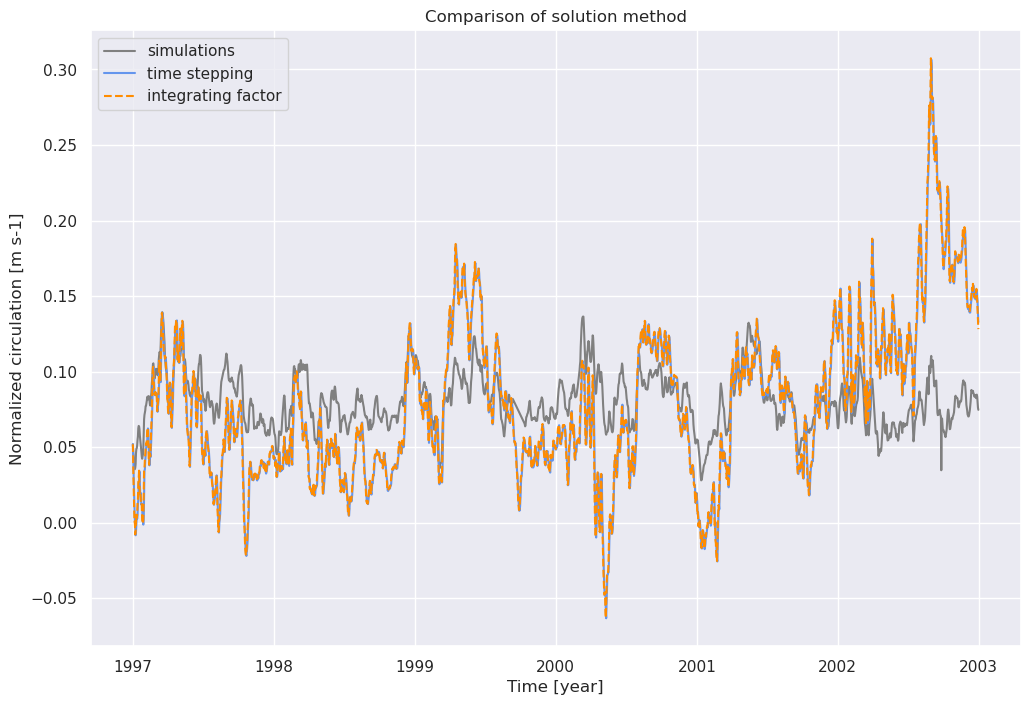

In [135]:
L = ts_L800.L_line
t = ts_L800.ocean_time

C = ts_L800.ucirc_area/L
C0 = C.isel(ocean_time=0).values
f_wind = ts_L800.taucirc_area.values/L
f_zbarflux = ts_L800.zbarflux_area.values/L
f_znodflux = ts_L800.znodflux_area.values/L
#f_fflux = ts_L800.fflux_area.values/L
f_ini = np.zeros_like(f_wind)

f_sum = f_wind+f_zbarflux+f_znodflux#+f_fflux

Rs = find_Rnod(ts_L800, Cd)
R = np.nanmean(Rs)

C_ts_ini = integrate(f_ini, dt, C0, friction="linear", R=R)
C_ts_wind = integrate(f_wind, dt, 0, friction="linear", R=R)
C_ts_zbarflux = integrate(f_zbarflux, dt, 0, friction="linear", R=R)
C_ts_znodflux = integrate(f_znodflux, dt, 0, friction="linear", R=R)
#C_ts_fflux = integrate(f_fflux, dt, 0, friction="linear", R=R)

C_if_ini = integrating_factor(f_ini, dt, C0, R, H)
C_if_wind = integrating_factor(f_wind, dt, 0, R, H)
C_if_zbarflux = integrating_factor(f_zbarflux, dt, 0, R, H)
C_if_znodflux = integrating_factor(f_znodflux, dt, 0, R, H)
#C_if_fflux = integrating_factor(f_fflux, dt, 0, R, H)

C_ts = integrate(f_sum, dt, C0, friction="linear", R=R)
C_if = integrating_factor(f_sum, dt, C0, R, H)

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(t, C, color="gray", label = "simulations")

ax.plot(t, C_ts, label="time stepping", color="cornflowerblue")
ax.plot(t, C_if, label="integrating factor", ls="--", color="darkorange")

#ax.plot(t, C_ts_ini+C_ts_wind+C_ts_zbarflux+C_ts_znodflux, label="time stepping term-wise")
#ax.plot(t, C_if_ini+C_if_wind+C_if_zbarflux+C_if_znodflux, label="integrating factor term-wise", ls="--")
ax.set_title("Comparison of solution method")
ax.set_xlabel("Time [year]")
ax.set_ylabel("Normalized circulation [m s-1]")
ax.legend()

fig.savefig("../figures/compare_methods.pdf")

## Wind offset compared with vorticity fluxes

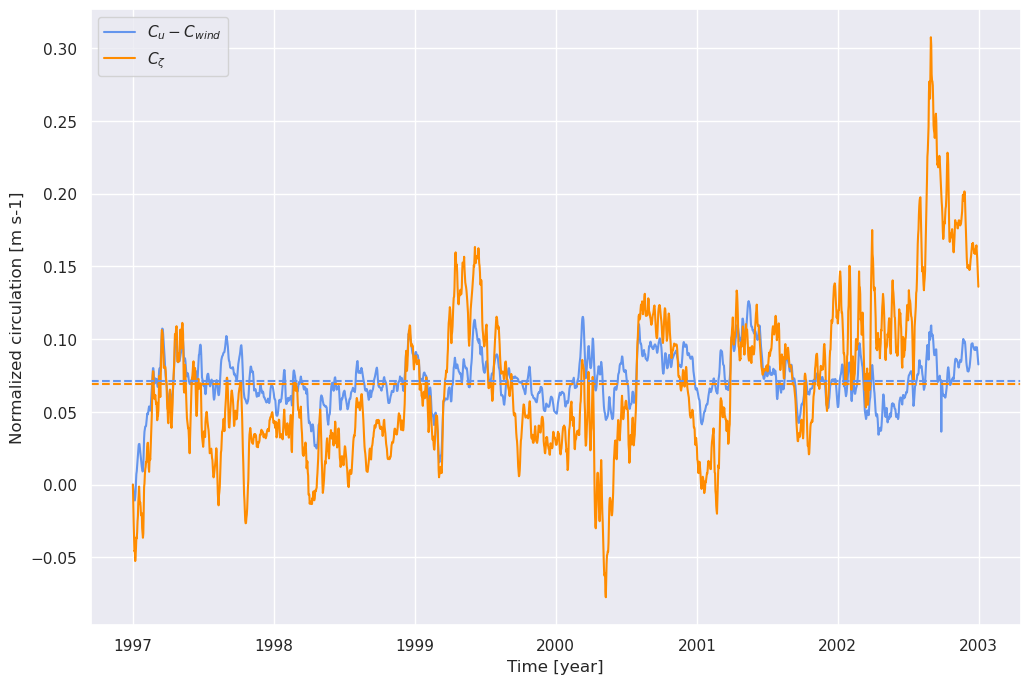

In [96]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(t, C-(C_if_wind+C_if_ini), label = r"$C_u - C_{wind}$", color="cornflowerblue")
ax.plot(t, C_if_zbarflux+C_if_znodflux, label = r"$C_{\zeta}$", color="darkorange")

# Add a horizontal line to represent the mean values
ax.axhline(np.mean(C-(C_if_wind+C_if_ini)), color="cornflowerblue", ls="--")
ax.axhline(np.mean(C_if_zbarflux+C_if_znodflux), color="darkorange", ls="--")

ax.set_xlabel("Time [year]")
ax.set_ylabel("Normalized circulation [m s-1]")
ax.legend()

## Adding error estimates

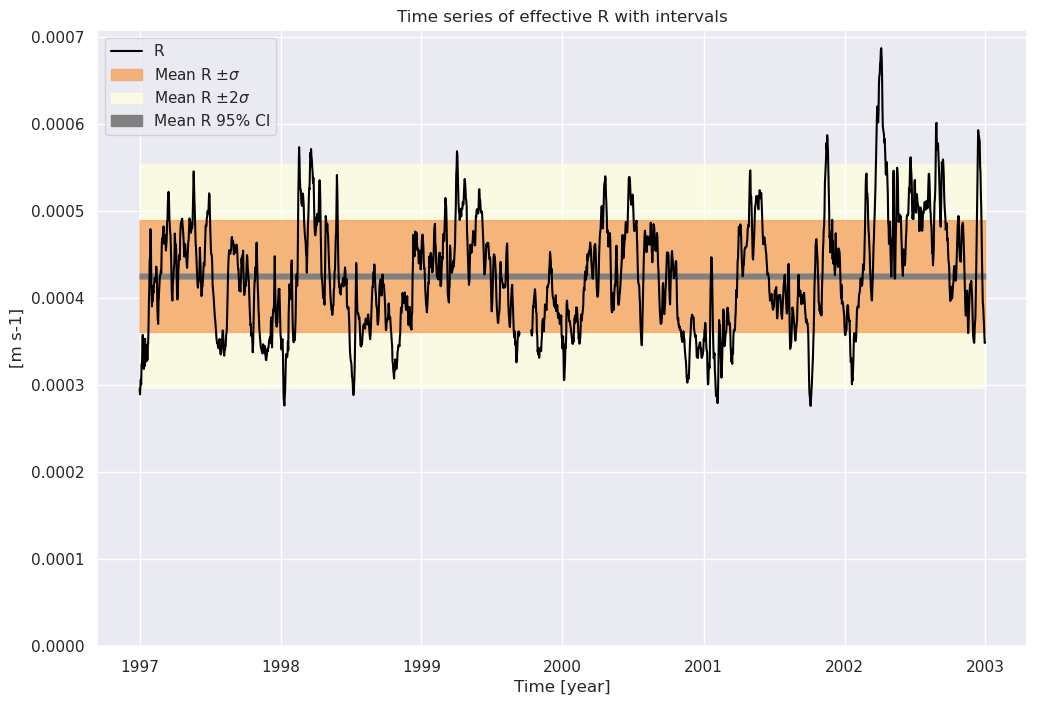

In [139]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(t, Rs, label="R", color="black")
ax.set_ylim(0, None)

Z = 1.96               # 95% confidense interval
s = np.nanstd(Rs)      # standard deviation
n = len(Rs)            # number of samples

Rl = R - Z*s/np.sqrt(n)
Ru = R + Z*s/np.sqrt(n)

Rls = np.ones_like(Rs)*Rl
Rus = np.ones_like(Rs)*Ru

Rsu = R + s 
Rsl = R - s 

Rsls = np.ones_like(Rs)*Rsl
Rsus = np.ones_like(Rs)*Rsu

R2su = R + 2*s 
R2sl = R - 2*s 

R2sls = np.ones_like(Rs)*R2sl
R2sus = np.ones_like(Rs)*R2su

ax.fill_between(t, Rsls, Rsus, color="sandybrown", alpha=0.8, label = r"Mean R $\pm \sigma$", zorder=1)
ax.fill_between(t, R2sls, R2sus, color="lightyellow", alpha=0.8, label = r"Mean R $\pm 2\sigma$", zorder=0)
ax.fill_between(t, Rls, Rus, color="gray", label = "Mean R 95% CI")

ax.set_xlabel("Time [year]")
ax.set_ylabel("[m s-1]")
ax.legend()
ax.set_title("Time series of effective R with intervals")

fig.savefig("../figures/R_intervals.pdf")

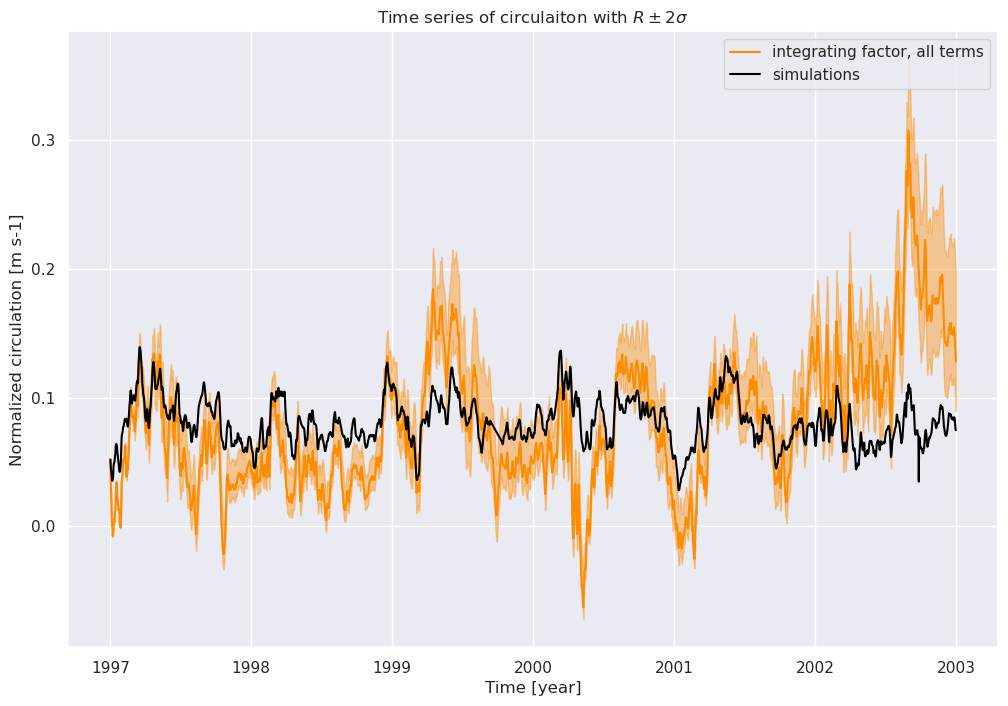

In [138]:
fig, ax = plt.subplots(figsize=(12,8))

s = 2*np.nanstd(Rs)  

C_if_u = integrating_factor(f_sum, dt, C0, R-s, H)
C_if_l = integrating_factor(f_sum, dt, C0, R+s, H)




ax.plot(t, C_if, label="integrating factor, all terms", color="darkorange")
ax.fill_between(t, C_if_l, C_if_u, color="darkorange", alpha=0.4)

ax.plot(t, C, color="black", label = "simulations")

ax.set_title(r"Time series of circulaiton with $R \pm 2\sigma$")
ax.legend()
ax.set_xlabel("Time [year]")
ax.set_ylabel("Normalized circulation [m s-1]")

fig.savefig("../figures/C_R_2sigma.pdf")

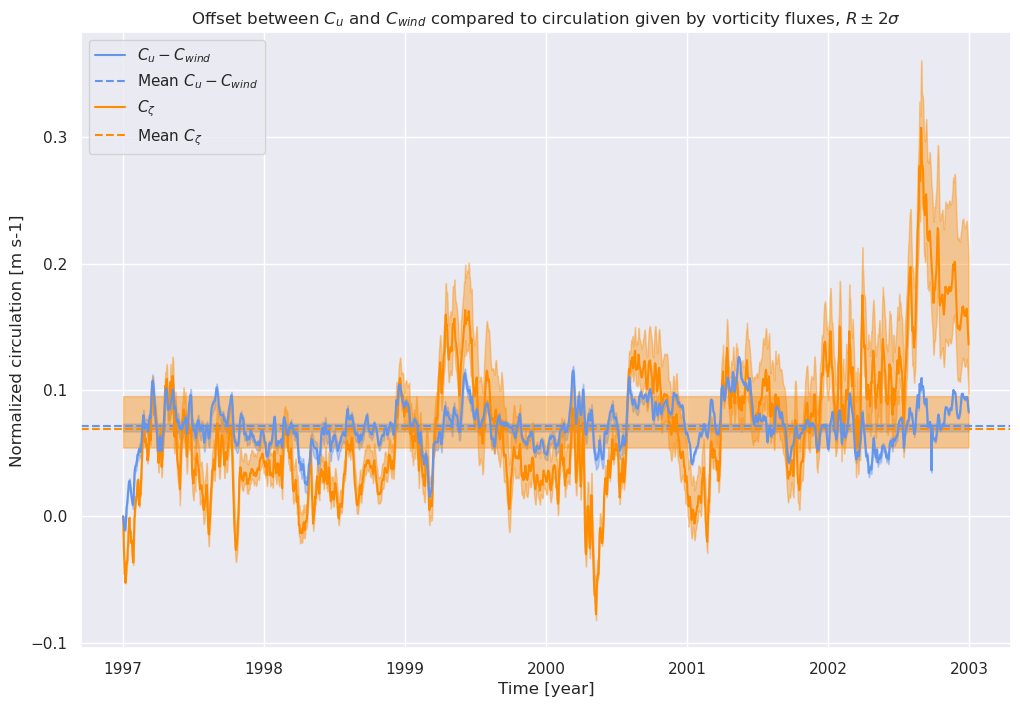

In [136]:
fig, ax = plt.subplots(figsize=(12,8))

s = 2*np.nanstd(Rs)  

C_if_ini_l = integrating_factor(f_ini, dt, C0, R+s, H)
C_if_ini_u = integrating_factor(f_ini, dt, C0, R-s, H)

C_if_wind_l = integrating_factor(f_wind, dt, 0, R+s, H)
C_if_wind_u = integrating_factor(f_wind, dt, 0, R-s, H)

C_if_vort_l = integrating_factor(f_zbarflux+f_znodflux, dt, 0, R+s, H)
C_if_vort_u = integrating_factor(f_zbarflux+f_znodflux, dt, 0, R-s, H)


ax.plot(t, C-(C_if_wind+C_if_ini), label = r"$C_u - C_{wind}$", color="cornflowerblue", zorder=10)
ax.fill_between(t, C-(C_if_wind_l+C_if_ini_l), C-(C_if_wind_u+C_if_ini_u), color="cornflowerblue", alpha=0.4)

# Add a horizontal line to represent the mean values
ax.axhline(np.mean(C-(C_if_wind+C_if_ini)), color="cornflowerblue", ls="--", label=r"Mean $C_u - C_{wind}$")
ax.fill_between(t, np.mean(C-(C_if_wind_l+C_if_ini_l)), np.mean(C-(C_if_wind_u+C_if_ini_u)), color="cornflowerblue", alpha=0.4)

ax.plot(t, C_if_zbarflux+C_if_znodflux, label = r"$C_{\zeta}$", color="darkorange", zorder=9)
ax.fill_between(t, C_if_vort_l, C_if_vort_u, color="darkorange", alpha=0.4)


ax.axhline(np.mean(C_if_zbarflux+C_if_znodflux), color="darkorange", ls="--", label = r"Mean $C_{\zeta}$")
ax.fill_between(t, np.mean(C_if_vort_l), np.mean(C_if_vort_u), color="darkorange", alpha=0.4)


ax.set_title(r"Offset between $C_u$ and $C_{wind}$ compared to circulation given by vorticity fluxes, $R \pm 2\sigma$")

ax.set_xlabel("Time [year]")
ax.set_ylabel("Normalized circulation [m s-1]")
ax.legend()

#fig.savefig("../figures/offset_comparison_R_2sigma.pdf")

In [ ]:
# save timeseries

